# **Homework1 Exploration & Exploitation**  
Napat Aeimwiratchai 65340500020

## Import library

In [313]:
import numpy as np
import matplotlib.pyplot as plt

## Bandit class

Create Bandit class for input config parameters (n_bandits, rewards per per bandit, standard diviation for distribution rewards)

    a. A constructor which initializes an agent with learnable parameters, and steps for each action.  
    b. A function which returns a reward signal.

In [314]:
class Bandit:
    def __init__(self, n_bandits, rewards, sd):
        self.n_bandits = n_bandits          # Number of bandit
        self.rewards = rewards              # Rewards per bandit
        self.sd = sd                        # Standard Diviation (Reward distribution)
    
    def pull(self, action):
        return np.random.normal(loc=self.rewards[action], scale=self.sd)    # Random reward from normal distribution

## Agent class

Create Agent class that can select which algorithm/stratigies should run (Epsilon-greedy, UCB) and Update function.

    a. A constructor which initializes an agent with learnable parameters, and steps for each action.
    b. An update function that updates the agent’s learnable parameters and steps.

In [315]:
class Agent:
    def __init__(self, n_bandits, epsilon=0.1, ucb_c=2):
        self.n_bandits = n_bandits
        self.epsilon = epsilon
        self.ucb_c = ucb_c
        self.q_estimated = np.zeros(n_bandits)  # Estimated reward values
        self.action_counts = np.zeros(n_bandits)  # Action selection counts
        self.total_steps = 0
    
    def select_action_epsilon_greedy(self):
        if np.random.rand() < self.epsilon:
            return  np.random.randint(0,self.n_bandits)  # Explore
        else:
            return np.argmax(self.q_estimated)  # Exploit
        
    
    def select_action_ucb(self):
        self.total_steps += 1
        if 0 in self.action_counts:
            return np.argmin(self.action_counts)  #  Check each action is selected at least once 
        ucb_values = self.q_estimated + self.ucb_c * np.sqrt(np.log(self.total_steps) / (self.action_counts + 1e-5))
        return np.argmax(ucb_values)
    
    def update(self, action, reward):
        self.action_counts[action] += 1
        alpha = 1.0 / self.action_counts[action]  # Incremental update rule
        self.q_estimated[action] += alpha * (reward - self.q_estimated[action])

## Simulation Script #1 (Difference epsilon , c_value)

This part is for running experiment for observe Bandits behavior in vary configuration (epsilon, c_value)

### Function code for run experiment and plot graph

In [316]:
def run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=False, ucb_c=0.1):
    bandit = Bandit(n_bandits, rewards, sd)             # Create Bandit 
    agent = Agent(n_bandits, epsilon, ucb_c)            # Create Agent
    rewards_log = np.zeros((n_bandits, time_steps))     # Create rewards log for each bandit per time steps
    
    # Condition for Select UCB or epsilon greedy
    for t in range(time_steps):
        if ucb:
            action = agent.select_action_ucb()
        else:
            action = agent.select_action_epsilon_greedy()
        # print((agent.q_estimated))
        reward = bandit.pull(action)            # random reward from pull (n) bandit
        agent.update(action, reward)            # update
        rewards_log[action, t] = reward         # Collect reward log 
    
    return rewards_log

In [317]:
def plot_results(n_bandits, rewards, sd, time_steps, epsilon, ucb_c):
    # Running experiment for both UCB and epsilod greedy
    rewards_epsilon_greedy = run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=False, ucb_c=ucb_c)
    rewards_ucb = run_experiment(n_bandits, rewards, sd, time_steps, epsilon, ucb=True, ucb_c=ucb_c)

    # Create time step for plot [0, timesteps]
    time_full = np.arange(time_steps) + 1  

    # Find Best bandit
    total_rewards_epsilon = np.sum(rewards_epsilon_greedy, axis=1)  # Sum of rewards per bandit (Epsilon-Greedy)
    total_rewards_ucb = np.sum(rewards_ucb, axis=1)  # Sum of rewards per bandit (UCB)

    best_bandit_epsilon = np.argmax(total_rewards_epsilon)  # Best bandit for Epsilon-Greedy
    best_bandit_ucb = np.argmax(total_rewards_ucb)  # Best bandit for UCB

    print(f"- Best Bandit (Epsilon-Greedy): Bandit {best_bandit_epsilon} with Total Reward = {total_rewards_epsilon[best_bandit_epsilon]:.2f}")
    print(f"- Best Bandit (UCB): Bandit {best_bandit_ucb} with Total Reward = {total_rewards_ucb[best_bandit_ucb]:.2f}")
    
    fig, axes = plt.subplots(3, 2, figsize=(16, 14))  

    # Cumulative Reward Plots 
    # Epsilon cum rewards (log)
    for i in range(n_bandits):
        axes[0, 0].plot(time_full, np.cumsum(rewards_epsilon_greedy[i, :] , axis=0) , label=f"Bandit {i}")
    axes[0, 0].set_xscale("log")
    axes[0, 0].set_title(f"Cumulative Reward - Epsilon Greedy (Log scale)")
    axes[0, 0].set_xlabel("Time Steps (Log Scale)")
    axes[0, 0].set_ylabel("Cumulative Reward")
    axes[0, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[0, 0].grid(True, which="both", linestyle="--", linewidth=0.5)

    # UCB cum rewards (log)
    for i in range(n_bandits):
        axes[0, 1].plot(time_full, np.cumsum(rewards_ucb[i, :]) , label=f"Bandit {i}")
    axes[0, 1].set_xscale("log")
    axes[0, 1].set_title(f"Cumulative Reward - UCB (Log scale)")
    axes[0, 1].set_xlabel("Time Steps (Log Scale)")
    axes[0, 1].set_ylabel("Cumulative Reward")
    axes[0, 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[0, 1].grid(True, which="both", linestyle="--", linewidth=0.5)

    # Epsilon cum rewards (linear)
    for i in range(n_bandits):
        axes[1, 0].plot(time_full, np.cumsum(rewards_epsilon_greedy[i, :]), alpha=1.0, label=f"Bandit {i}")
    axes[1, 0].set_title("Cumulative Rewards - Epsilon-Greedy (Linear scale)")
    axes[1, 0].set_xlabel("Time Steps (Linear Scale)")
    axes[1, 0].set_ylabel("Cumulative Reward")
    axes[1, 0].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].grid(True, linestyle="--", linewidth=0.5)

    # UCB cum rewards (linear)
    for i in range(n_bandits):
        axes[1, 1].plot(time_full, np.cumsum(rewards_ucb[i, :]), alpha=0.8, label=f"Bandit {i}")
    axes[1, 1].set_title("Cumulative Rewards - UCB (Linear scale)")
    axes[1, 1].set_xlabel("Time Steps (Linear Scale)")
    axes[1, 1].set_ylabel("Cumulative Reward")
    axes[1, 1].legend(loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 1].grid(True, linestyle="--", linewidth=0.5)

    # Epsilon Total reward each bandit (Histogram)
    axes[2, 0].bar(range(n_bandits), total_rewards_epsilon, color='blue', alpha=0.7, edgecolor="black")
    axes[2, 0].set_title("Total Rewards per Bandit - Epsilon-Greedy")
    axes[2, 0].set_xlabel("Bandit Number")
    axes[2, 0].set_ylabel("Total Reward")
    axes[2, 0].set_xticks(range(n_bandits))
    axes[2, 0].grid(axis='y', linestyle='--', alpha=0.7)

    # UCB Total reward each bandit (Histogram)
    axes[2, 1].bar(range(n_bandits), total_rewards_ucb, color='red', alpha=0.7, edgecolor="black")
    axes[2, 1].set_title("Total Rewards per Bandit - UCB")
    axes[2, 1].set_xlabel("Bandit Number")
    axes[2, 0].set_ylabel("Total Reward")
    axes[2, 1].set_xticks(range(n_bandits))
    axes[2, 1].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle(f"Comparison of Epsilon-Greedy and UCB Algorithms(ε = {epsilon} ,c={ucb_c})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    return rewards_epsilon_greedy, rewards_ucb


### Define parameter for multi armed bandits (Difference config)

In [318]:
# Define rewards for the bandits
n_bandits = 10          # Number of bandits
rewards_each_bandit = [0.1, 0.15, 0.21, 0.25, 0.4, 0.22, 0.15, 0.3, 0.25, 0.05]     # Reward per each bandit
sd = 1.0                # Standard diviation
time_step = 100000      # Running time step
epsilon_values = [0.01, 0.3, 0.5, 1.0]  # List of epsilon values (epsilon-greedy)
c_values = [0.01, 1, 5, 10]             # List of c value (UCB)

Definition of Variables  
- n_bandits : Number of bandits
- rewards_each_bandit : Fixed reward each bandit (mean reward)
- sd : Standard diviation for random around the mean reward
- time_step : Time step that this experiment run
- epsilon_values : A list of epsilon values for Epsilon-greedy
- c_values : A list of c values for UCB

|Bandit|Value|
|------|------|
|0|0.1|
|1|0.15|
|2|0.21|
|3|0.25|
|**4**|**0.4 best!**|
|5|0.22|
|6|0.15|
|7|0.3|
|8|0.25|
|9|0.05|

### Graph (Difference config)

This graph section run experiment with difference configuration [0.01, 0.3, 0.5, 1.0] for epsilon-greedy and [0.01, 1.0, 5.0, 10.0] for UCB.
Graph has 3 row (x value-timestep) and 2 column (Epsilon-Greedy & UCB)  

- First row, Cumulative reward each bandit (Log scale) 
- Second row, Cumulative reward each bandit (Linear scale) 
- Third row, Totol reward each bandit (Histrogram)

First two row of graph will show the same (Cumulative reward) result but in difference scale that can show the behavior of how fast it end of explore and try to exploit.  

The third graph is to see a total reward per bandit at 100k time steps, this can show how reward distribute to each bandit. If reward has highly distribute it explore more than exploit but if doesn't distribute or struct with only one bandit it can determine it has very fast to exploit. 

#### Epsilon = 0.01 & c_value = 0.01

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 38871.74
- Best Bandit (UCB): Bandit 4 with Total Reward = 39730.35


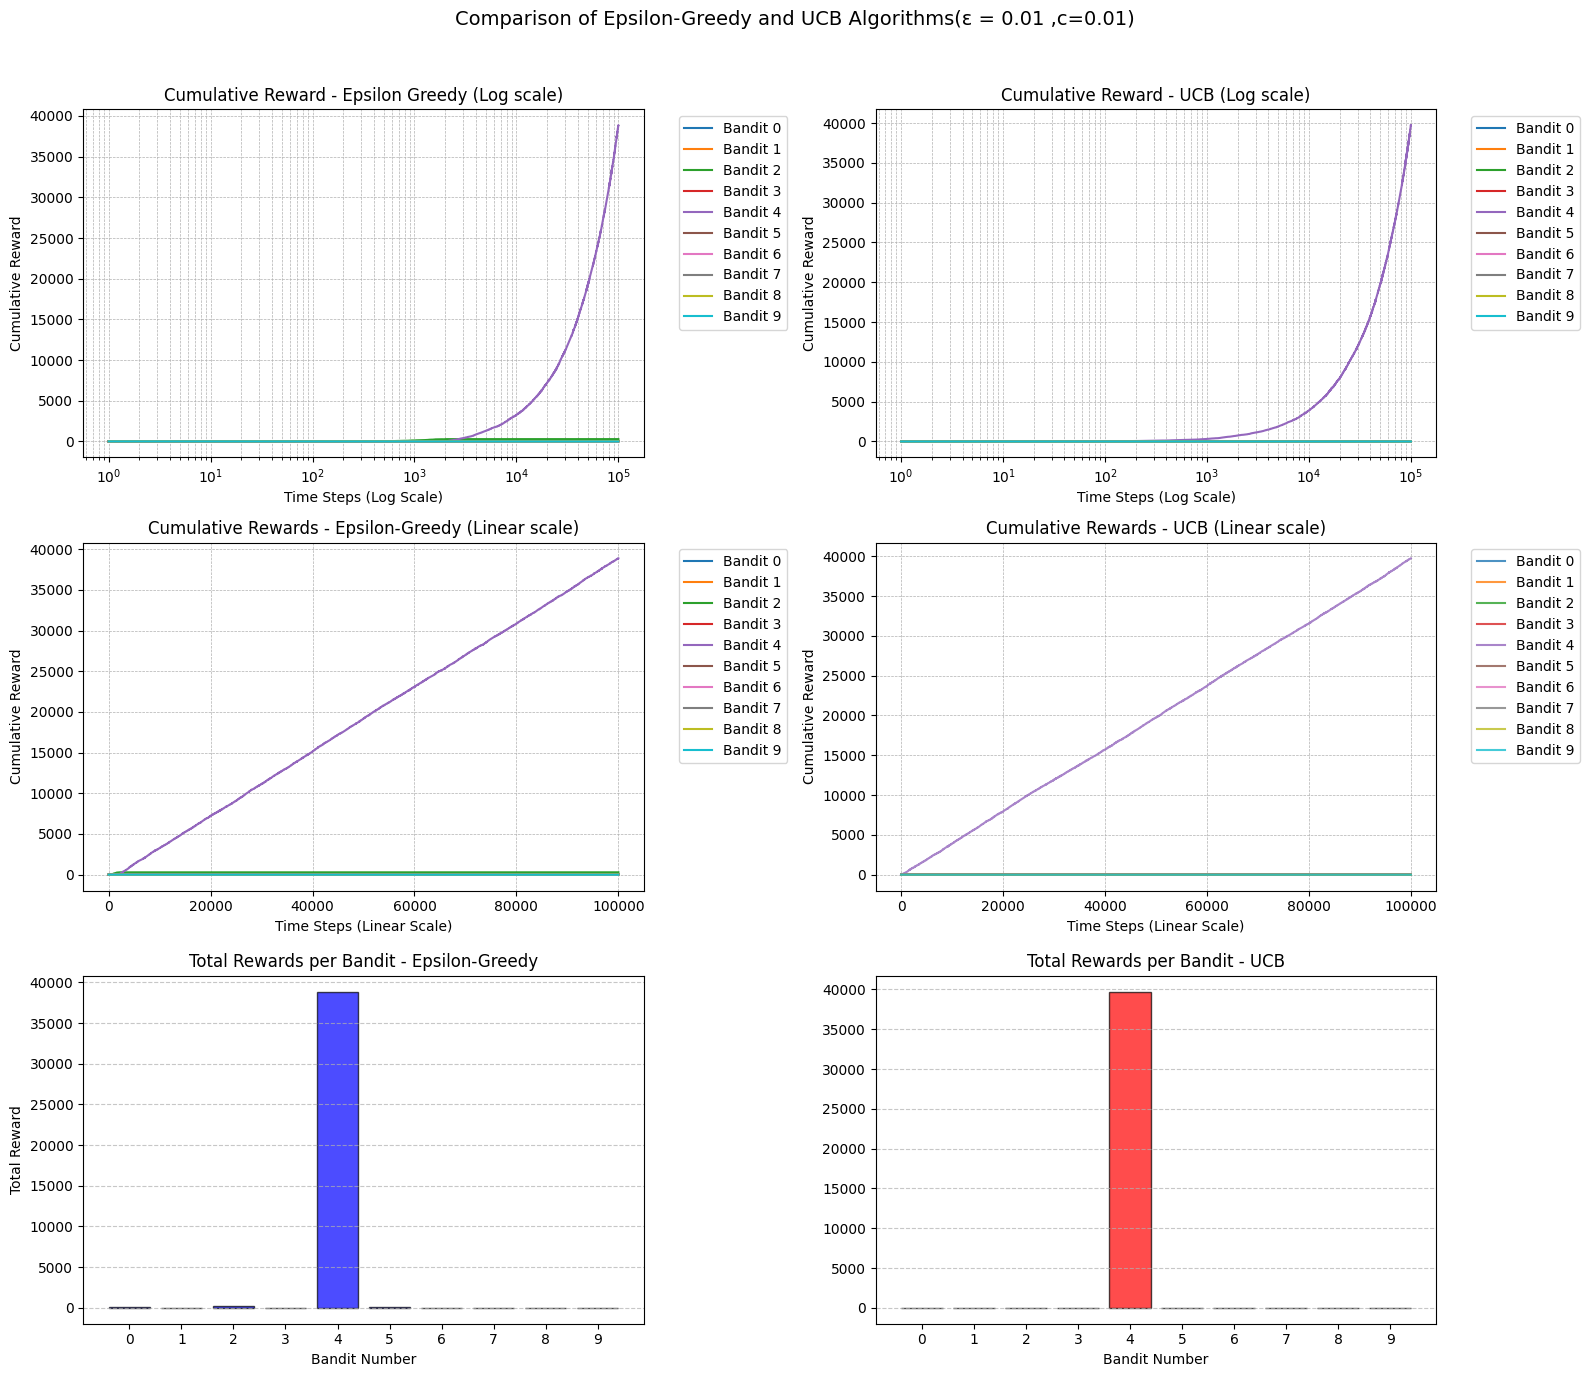

In [319]:
rew_epsilon_0, rew_ucb_0 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[0], ucb_c=c_values[0])

#### Epsilon = 0.3 & c_value = 1.0 

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 26773.07
- Best Bandit (UCB): Bandit 4 with Total Reward = 39861.41


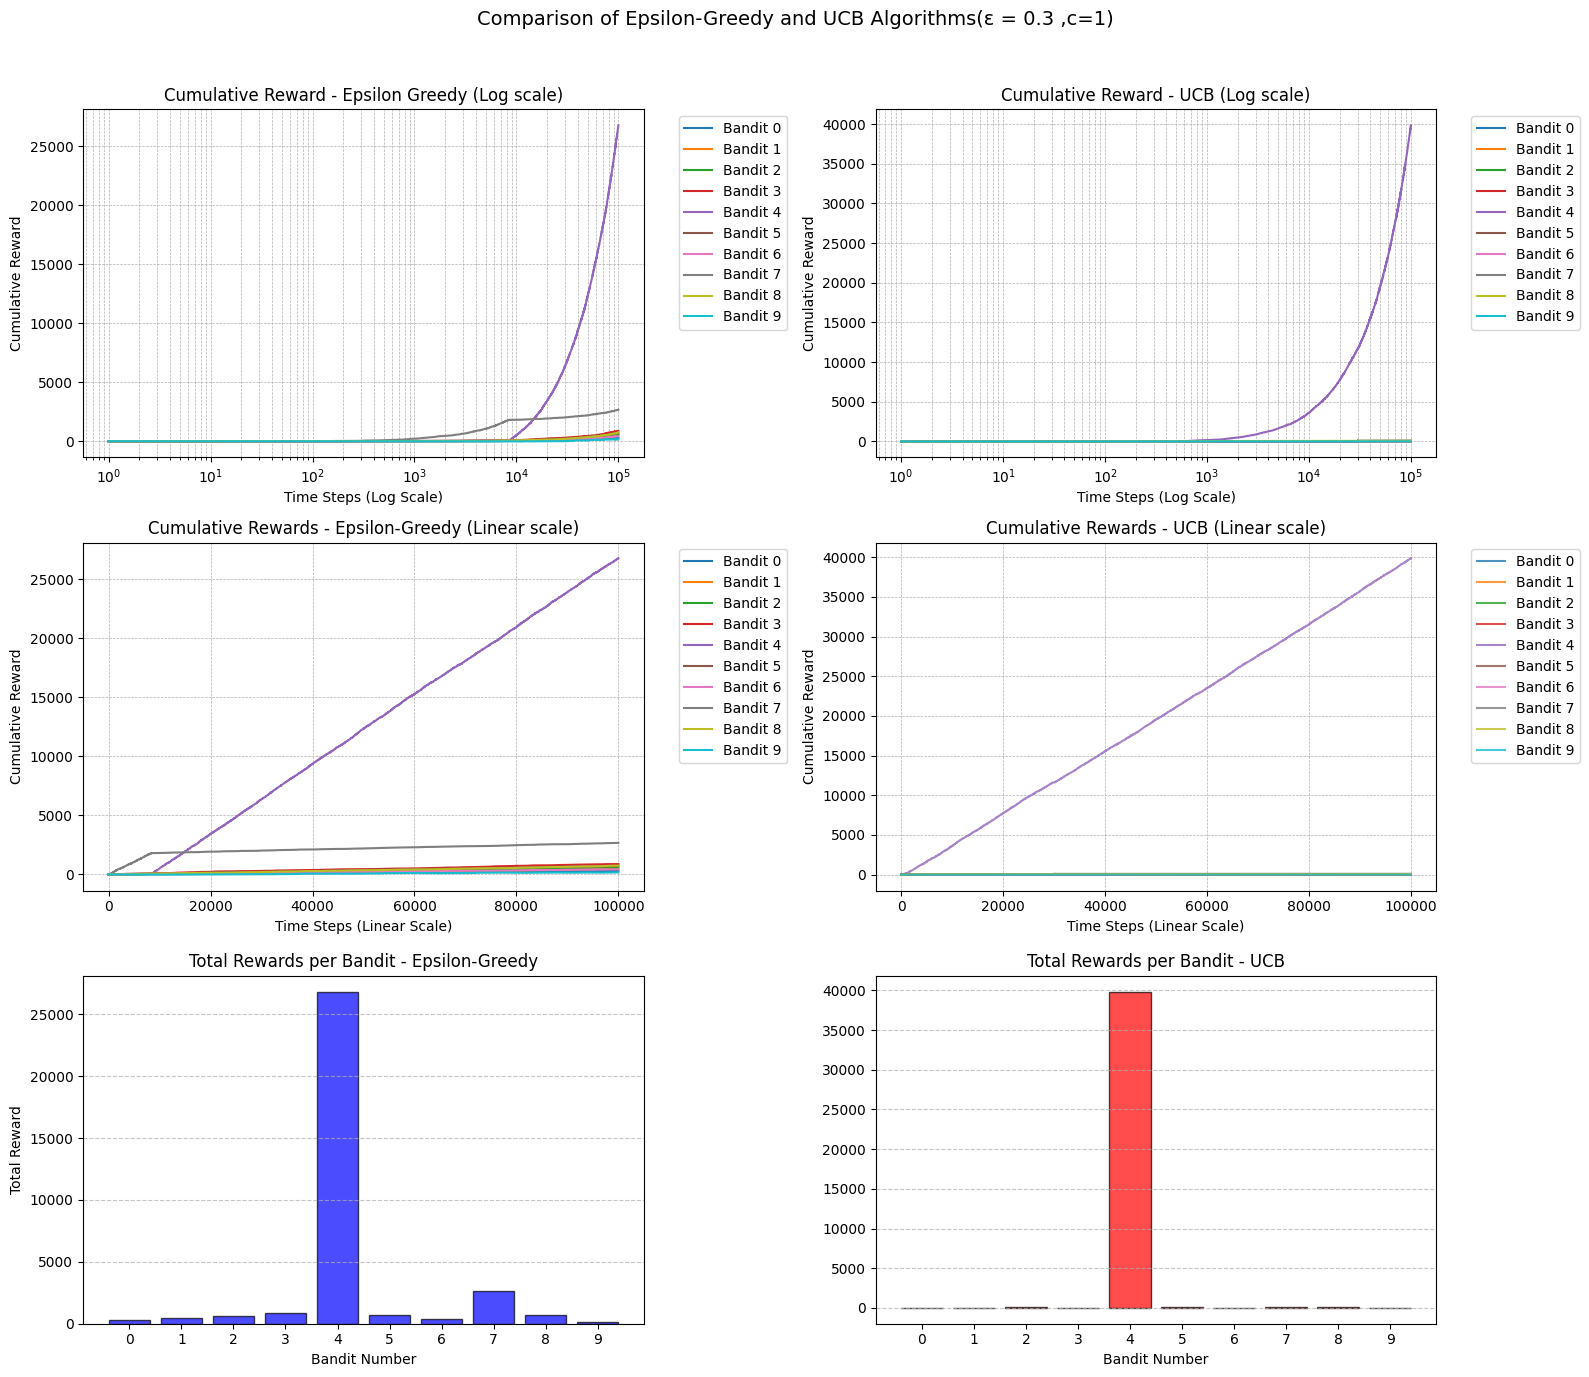

In [320]:
rew_epsilon_1, rew_ucb_1 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[1], ucb_c=c_values[1])

#### Epsilon = 0.5 & c_value = 5 

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 21873.57
- Best Bandit (UCB): Bandit 4 with Total Reward = 24104.93


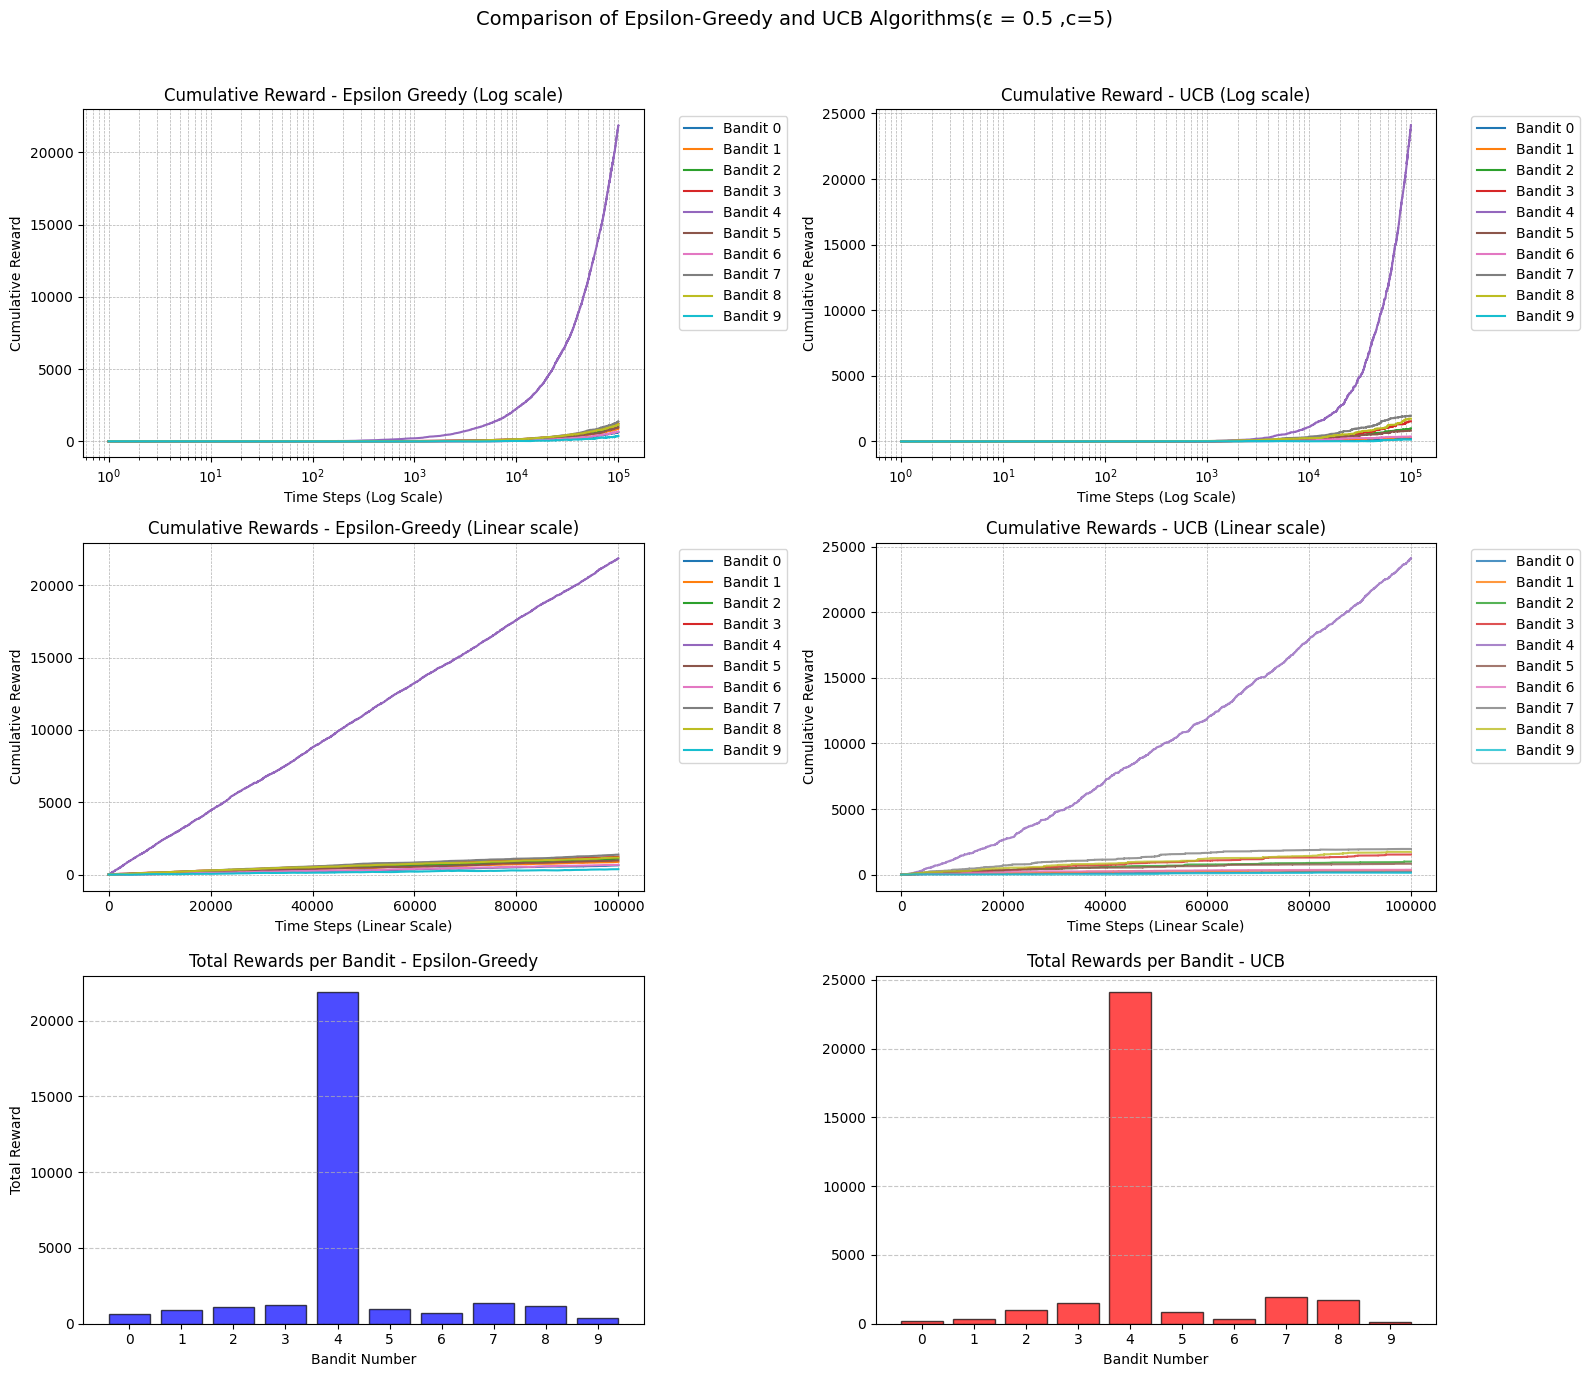

In [321]:
rew_epsilon_2, rew_ucb_2 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[2], ucb_c=c_values[2])

#### Epsilon = 1.0 & c_value = 10 

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 3922.74
- Best Bandit (UCB): Bandit 4 with Total Reward = 10742.88


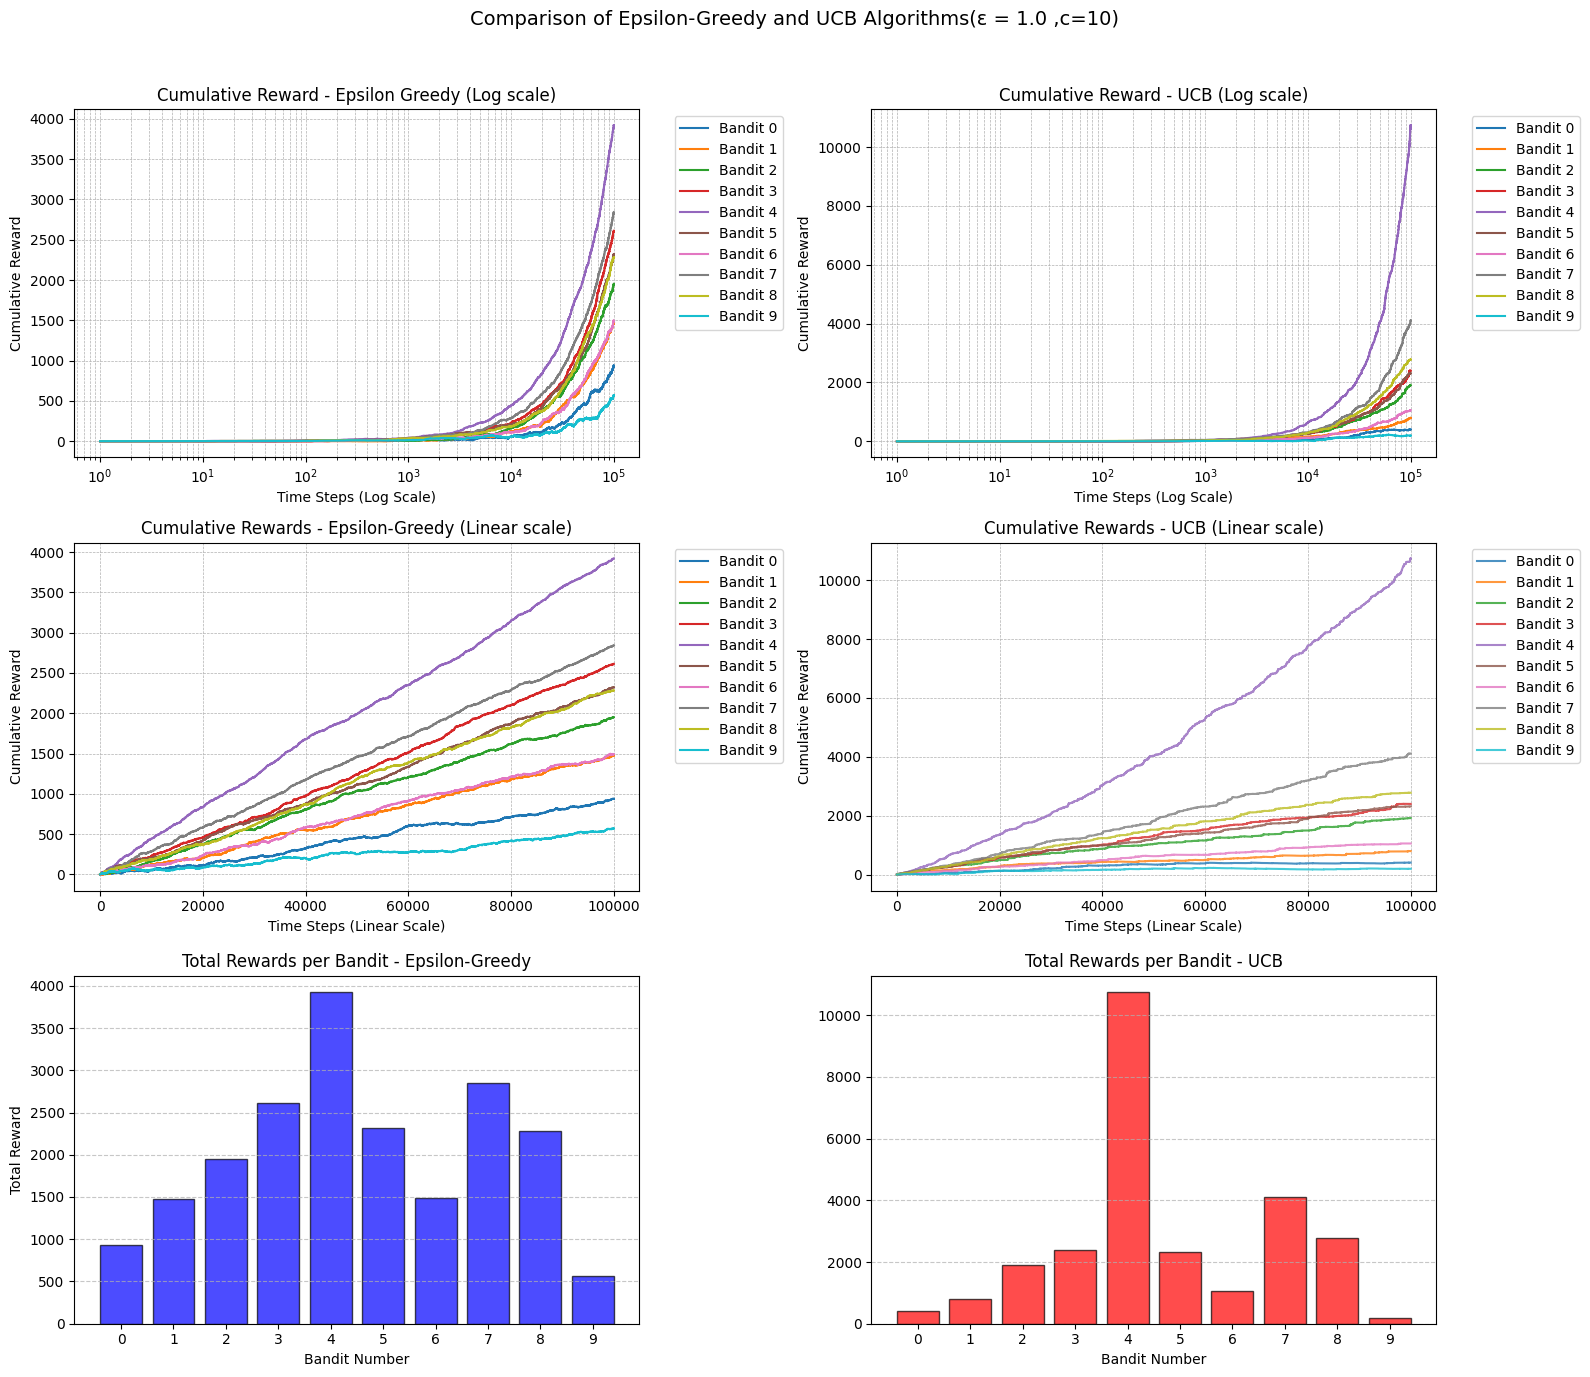

In [322]:
rew_epsilon_3, rew_ucb_3 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[3], ucb_c=c_values[3])

From the above graph for all difference config can select the best bandit (No. 4) for both algorithm but has some difference behavior on smallest value (epsilon , c_value) that can exploit too fast compare with the highest value that explore more but also can find the best bandit.

### Summarize for difference configuration

In [323]:
def extract_actions_from_rewards(reward_list):
    # Finding action from reward list 
    return [np.where(row != 0)[0] for row in reward_list]

def plot_bandit_selection_counts(reward_epsilon_list, reward_ucb_list, epsilon_values, c_values, n_bandits):
    # Extract actions from rewards
    action_epsilon_list = extract_actions_from_rewards(reward_epsilon_list)
    action_ucb_list = extract_actions_from_rewards(reward_ucb_list)
    
    # Count selections per bandit
    total_selection_list = [np.bincount(actions, minlength=n_bandits) for actions in action_epsilon_list] + \
                           [np.bincount(actions, minlength=n_bandits) for actions in action_ucb_list]

    method_labels = [f"Epsilon {eps}" for eps in epsilon_values] + [f"UCB c {c}" for c in c_values]
    final_selections = np.array(total_selection_list)

    # Bar width calculation based on number of methods
    num_configs = len(total_selection_list)
    bar_width = 0.8 / num_configs  # Dynamically adjust width

    plt.figure(figsize=(15, 7))

    # X-axis positions (Bandit indices)
    x_positions = np.arange(n_bandits)  
    shift = (num_configs - 1) * bar_width / 2  # Centering shift
    # Plot each method's bandit selection counts as a bar
    for i in range(num_configs):
        if i < len(epsilon_values):
            color = plt.cm.rainbow(i / (len(epsilon_values) + len(c_values)))  # Rainbow spectru
        else:
            color = plt.cm.rainbow((i + 1) / (len(epsilon_values) + len(c_values)))  # Rainbow spectrum
        plt.bar(x_positions - shift + i * bar_width, final_selections[i], width=bar_width, 
                label=method_labels[i], color=color, edgecolor="black")

    # Formatting
    plt.xlabel('Bandit Number', fontsize=14)
    plt.ylabel('Number of Times Selected', fontsize=14)
    plt.title('Bandit Selection Counts for Different Methods and Bandits', fontsize=16)

    # Adjust x-ticks to the middle of grouped bars
    plt.xticks(x_positions, [f'Bandit {b}' for b in x_positions])
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add grid for better readability
    plt.legend(title="Methods", fontsize=12)
    plt.tight_layout()

    plt.show()


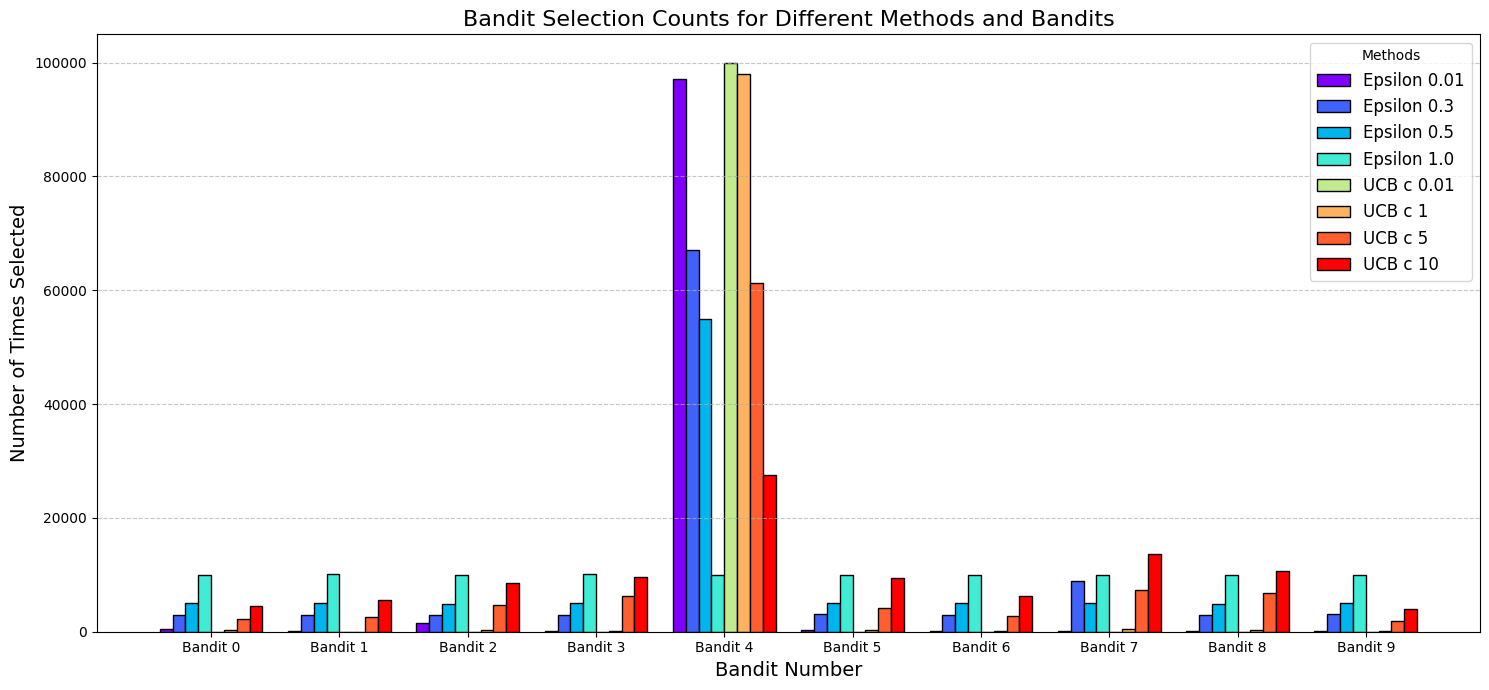

In [324]:
plot_bandit_selection_counts(
    reward_epsilon_list=[rew_epsilon_0, rew_epsilon_1, rew_epsilon_2, rew_epsilon_3],       # Adjustable reward from epsilon-greedy config
    reward_ucb_list=[rew_ucb_0, rew_ucb_1, rew_ucb_2, rew_ucb_3],                           # Adjustable reward from UCB config
    epsilon_values=epsilon_values,  # Example ε values
    c_values=c_values,  # Example UCB c values
    n_bandits=n_bandits # Numberr of Bandits
)

On the above graph, this graph show about how often each bandit was pulled.  
Horizontal line is a number of times that bandit was selected and vertical line is a bandit number.  
For all config can selected the best bandit !!!

**Epsilon-greedy**
- We can see on the lower Epsilon 0.01 (Dark purple) it highly select on only one bandit but when increase epsilon, number of selected will distribute to another bandit as you can see on the highest Epsilon 1.0 (Light green-Mint) the number of selected can seperate to all bandit almost same number of times.  

**UCB**  

- The lower c value 0.01 (Green) has same behavior like epsilon-greedy that mostly selected only one bandit but when increase c value it has more distribute to another bandit but can see which bandit has most selected. 

## Simulation Script #2 (Fixed epsilon , c_value)

This part is for running experiment for observe Bandits behavior in same configuration to see consistency behavior.

### Define parameter for multi armed bandits (Fixed config)

In [325]:
# Define parameter for the bandits
n_bandits = 10
rewards_each_bandit = [0.1, 0.15, 0.21, 0.25, 0.4, 0.22, 0.15, 0.3, 0.25, 0.05]
sd = 1.0
time_step = 100000
epsilon_values = [0.3, 0.3, 0.3, 0.3]
c_values = [0.3, 0.3, 0.3, 0.3]

Definition of Variables  
- n_bandits : Number of bandits
- rewards_each_bandit : Fixed reward each bandit (mean reward)
- sd : Standard diviation for random around the mean reward
- time_step : Time step that this experiment run
- epsilon_values : A list of epsilon values for Epsilon-greedy (same value for all)
- c_values : A list of c values for UCB (same value for all)

### Graph (Fixed config)

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 29401.76
- Best Bandit (UCB): Bandit 4 with Total Reward = 40022.09


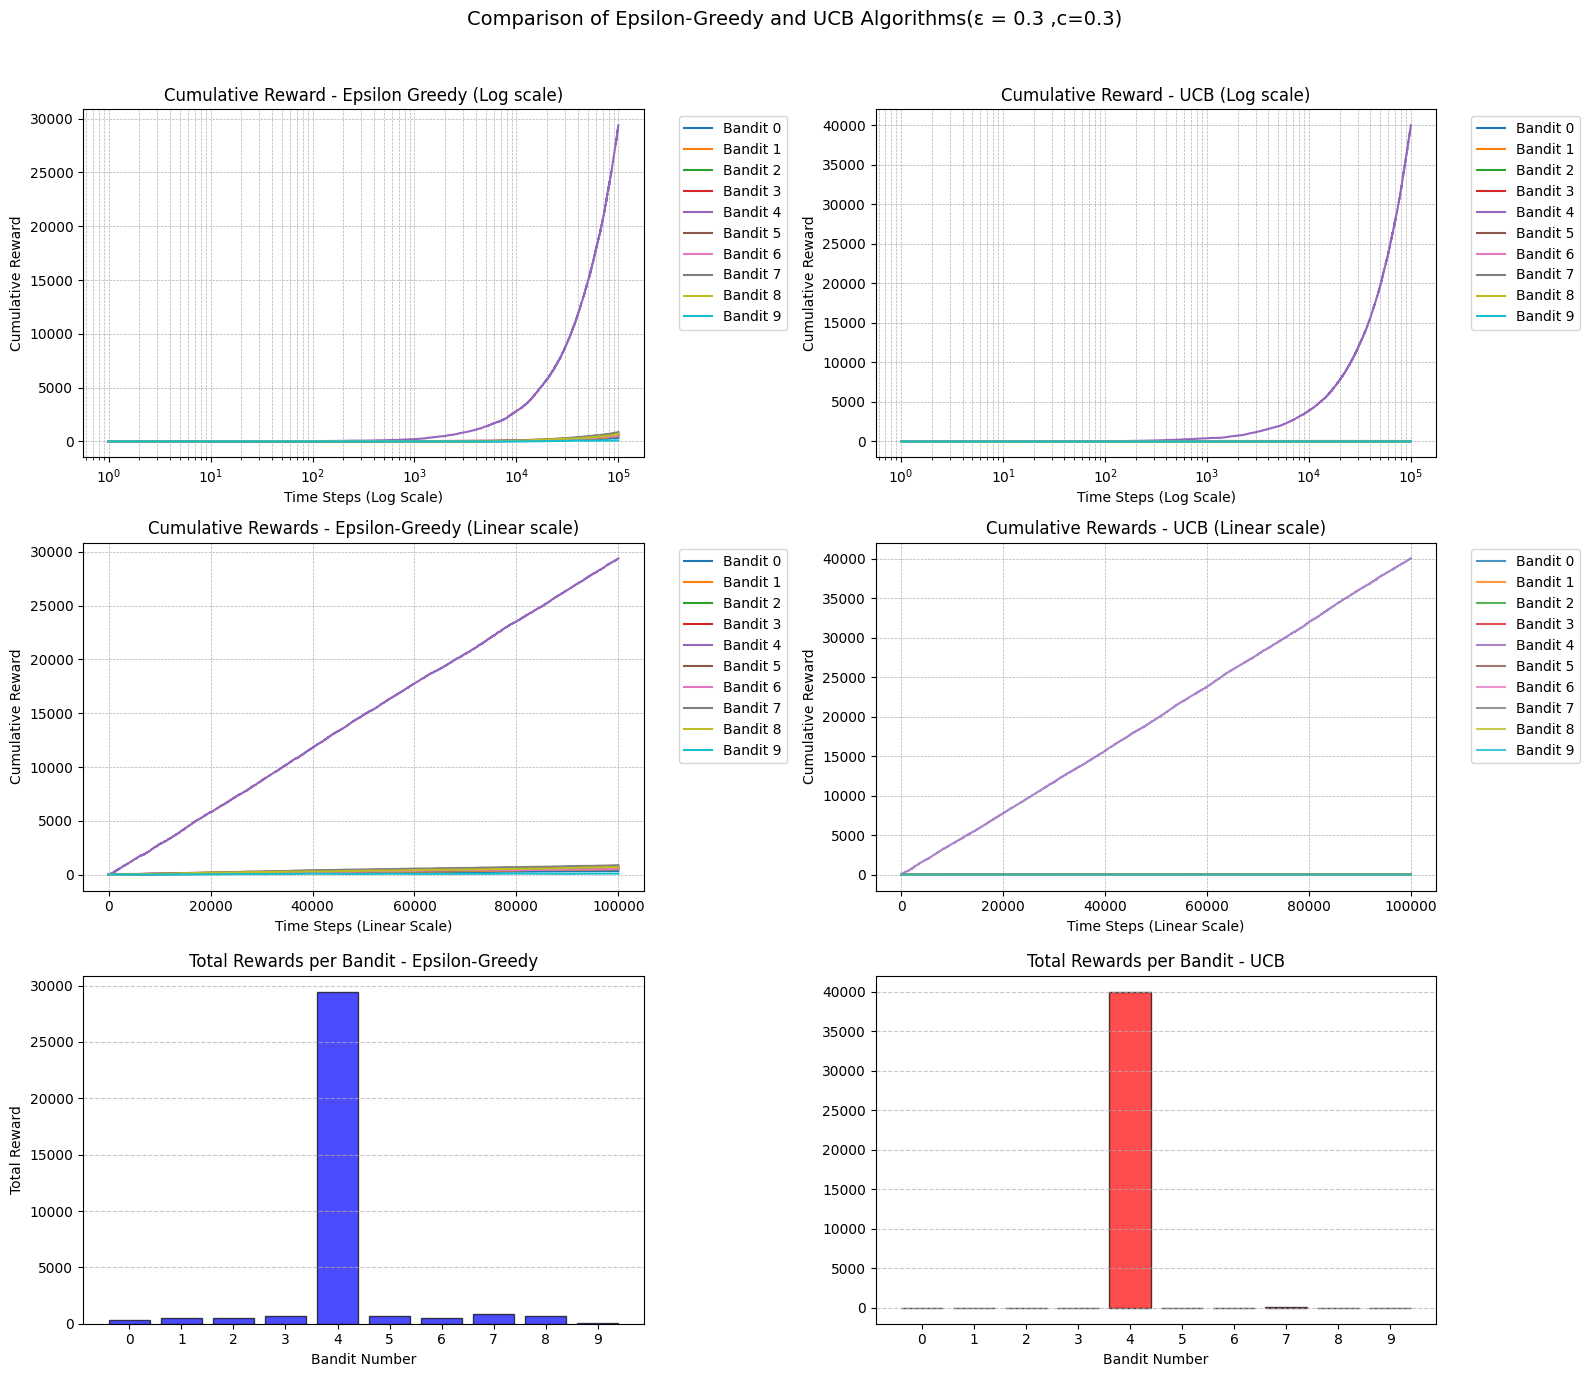

In [326]:
rew_epsilon_4, rew_ucb_4 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[0], ucb_c=c_values[0])

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 28868.92
- Best Bandit (UCB): Bandit 7 with Total Reward = 29879.36


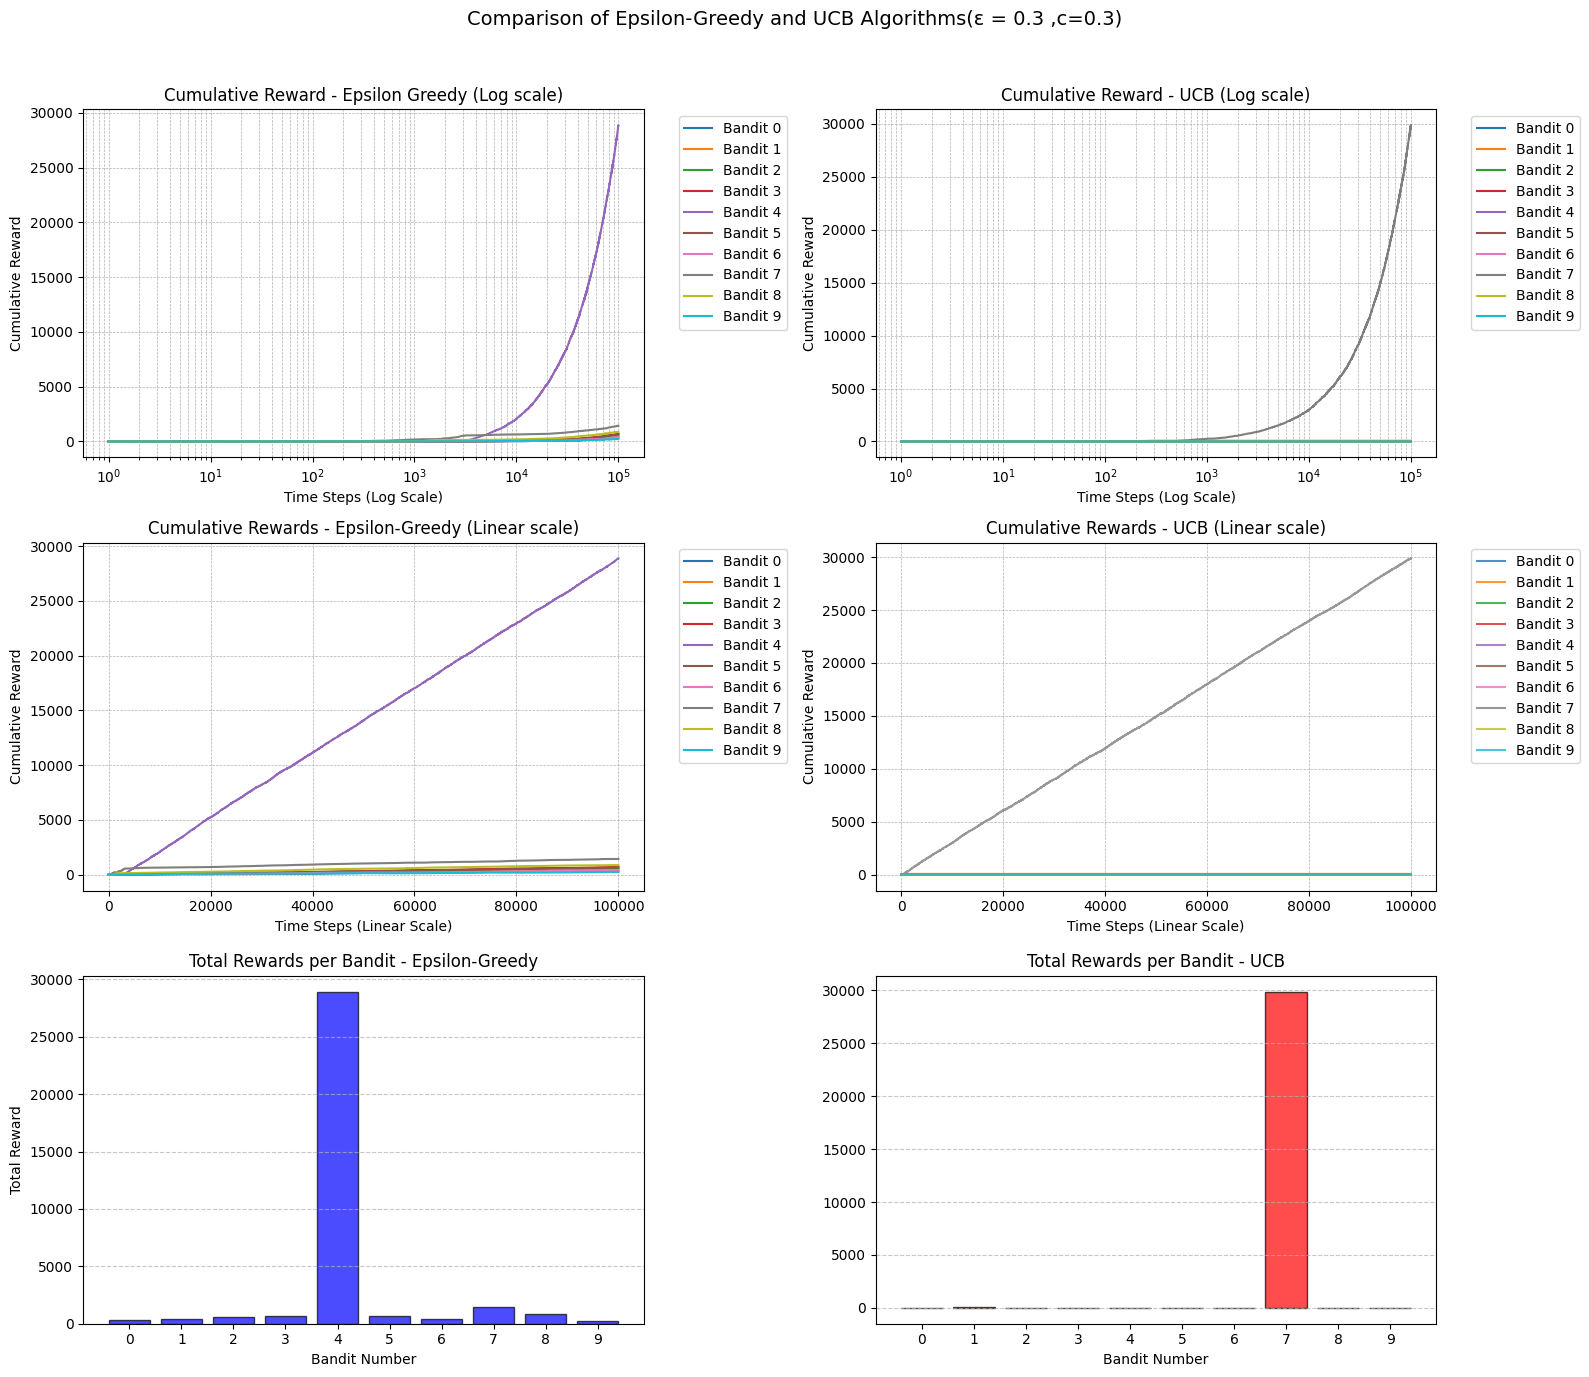

In [327]:
rew_epsilon_5, rew_ucb_5 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[1], ucb_c=c_values[1])

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 29014.65
- Best Bandit (UCB): Bandit 4 with Total Reward = 39504.83


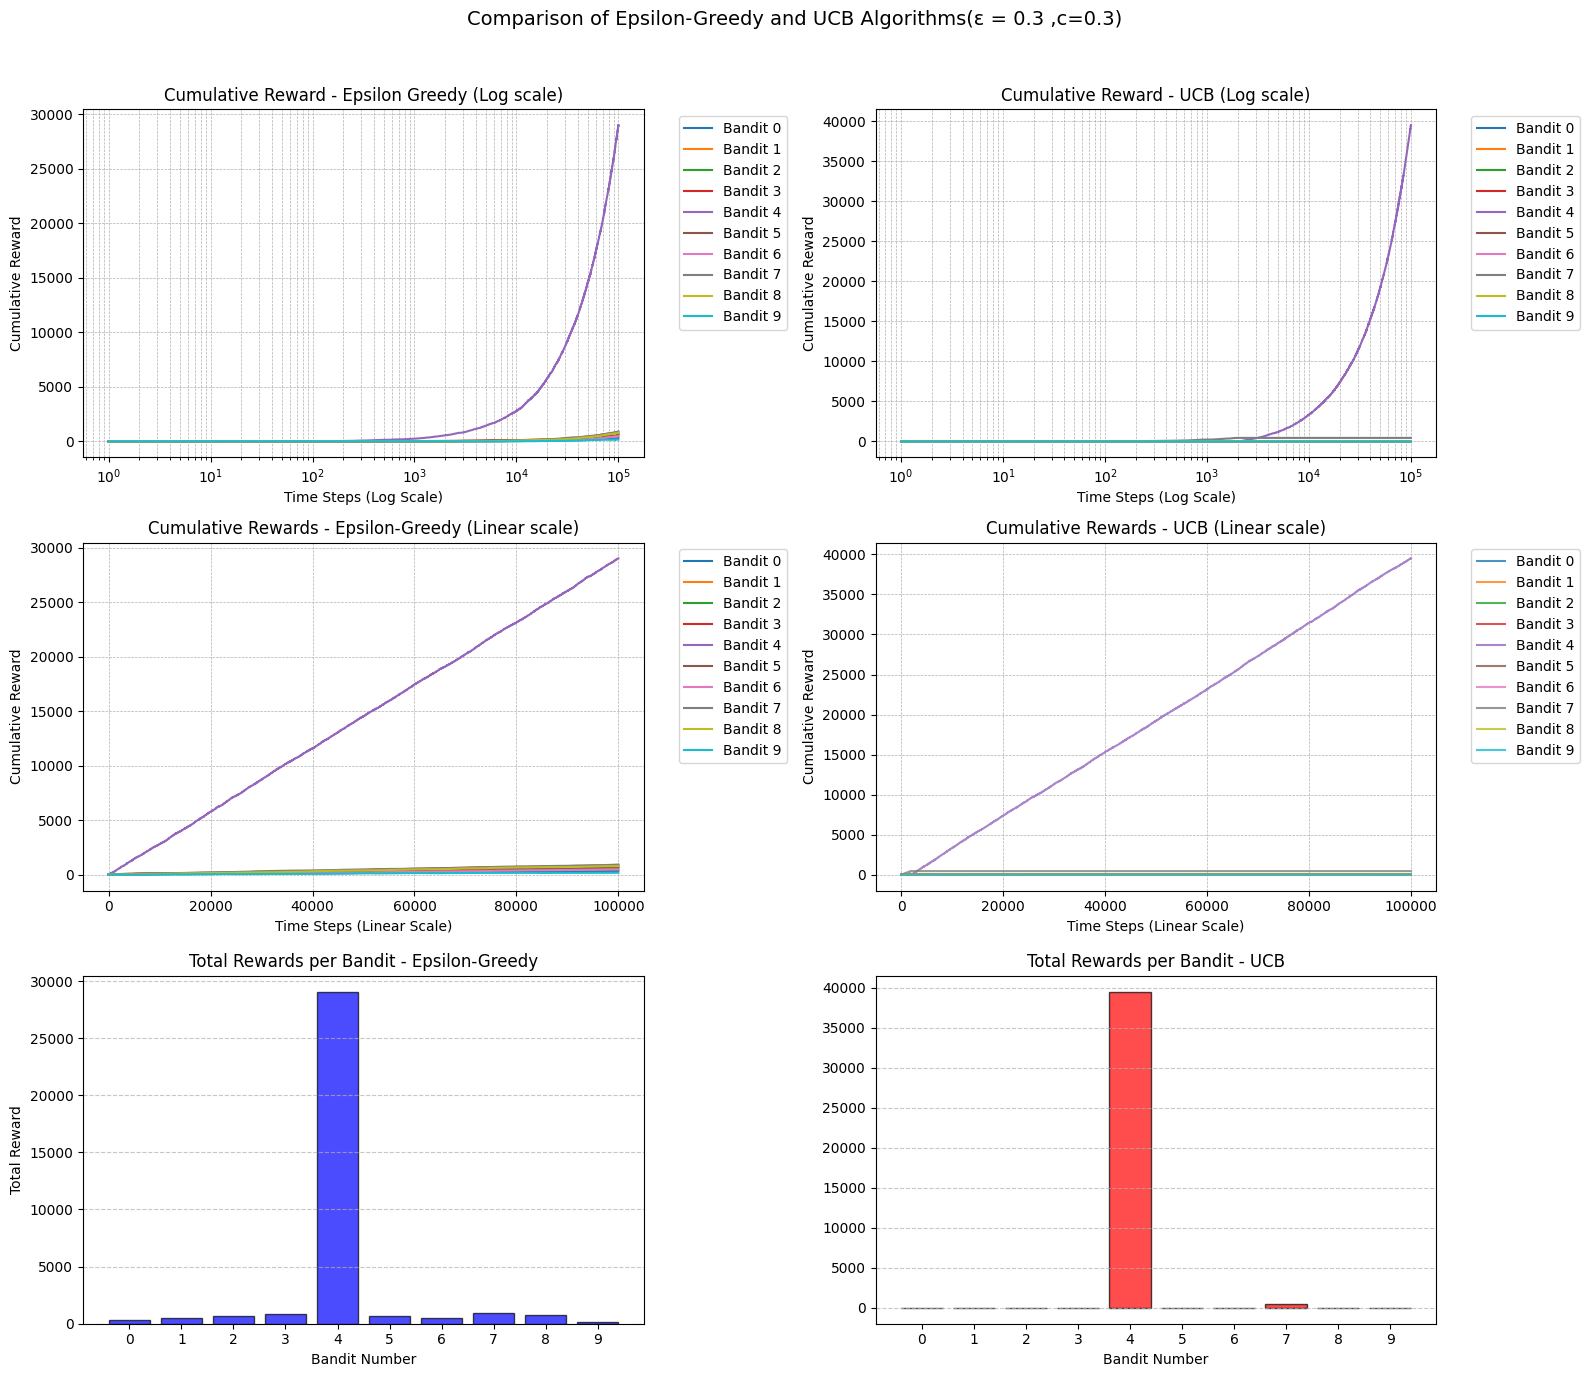

In [328]:
rew_epsilon_6, rew_ucb_6 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[2], ucb_c=c_values[2])

- Best Bandit (Epsilon-Greedy): Bandit 4 with Total Reward = 29136.32
- Best Bandit (UCB): Bandit 4 with Total Reward = 39416.91


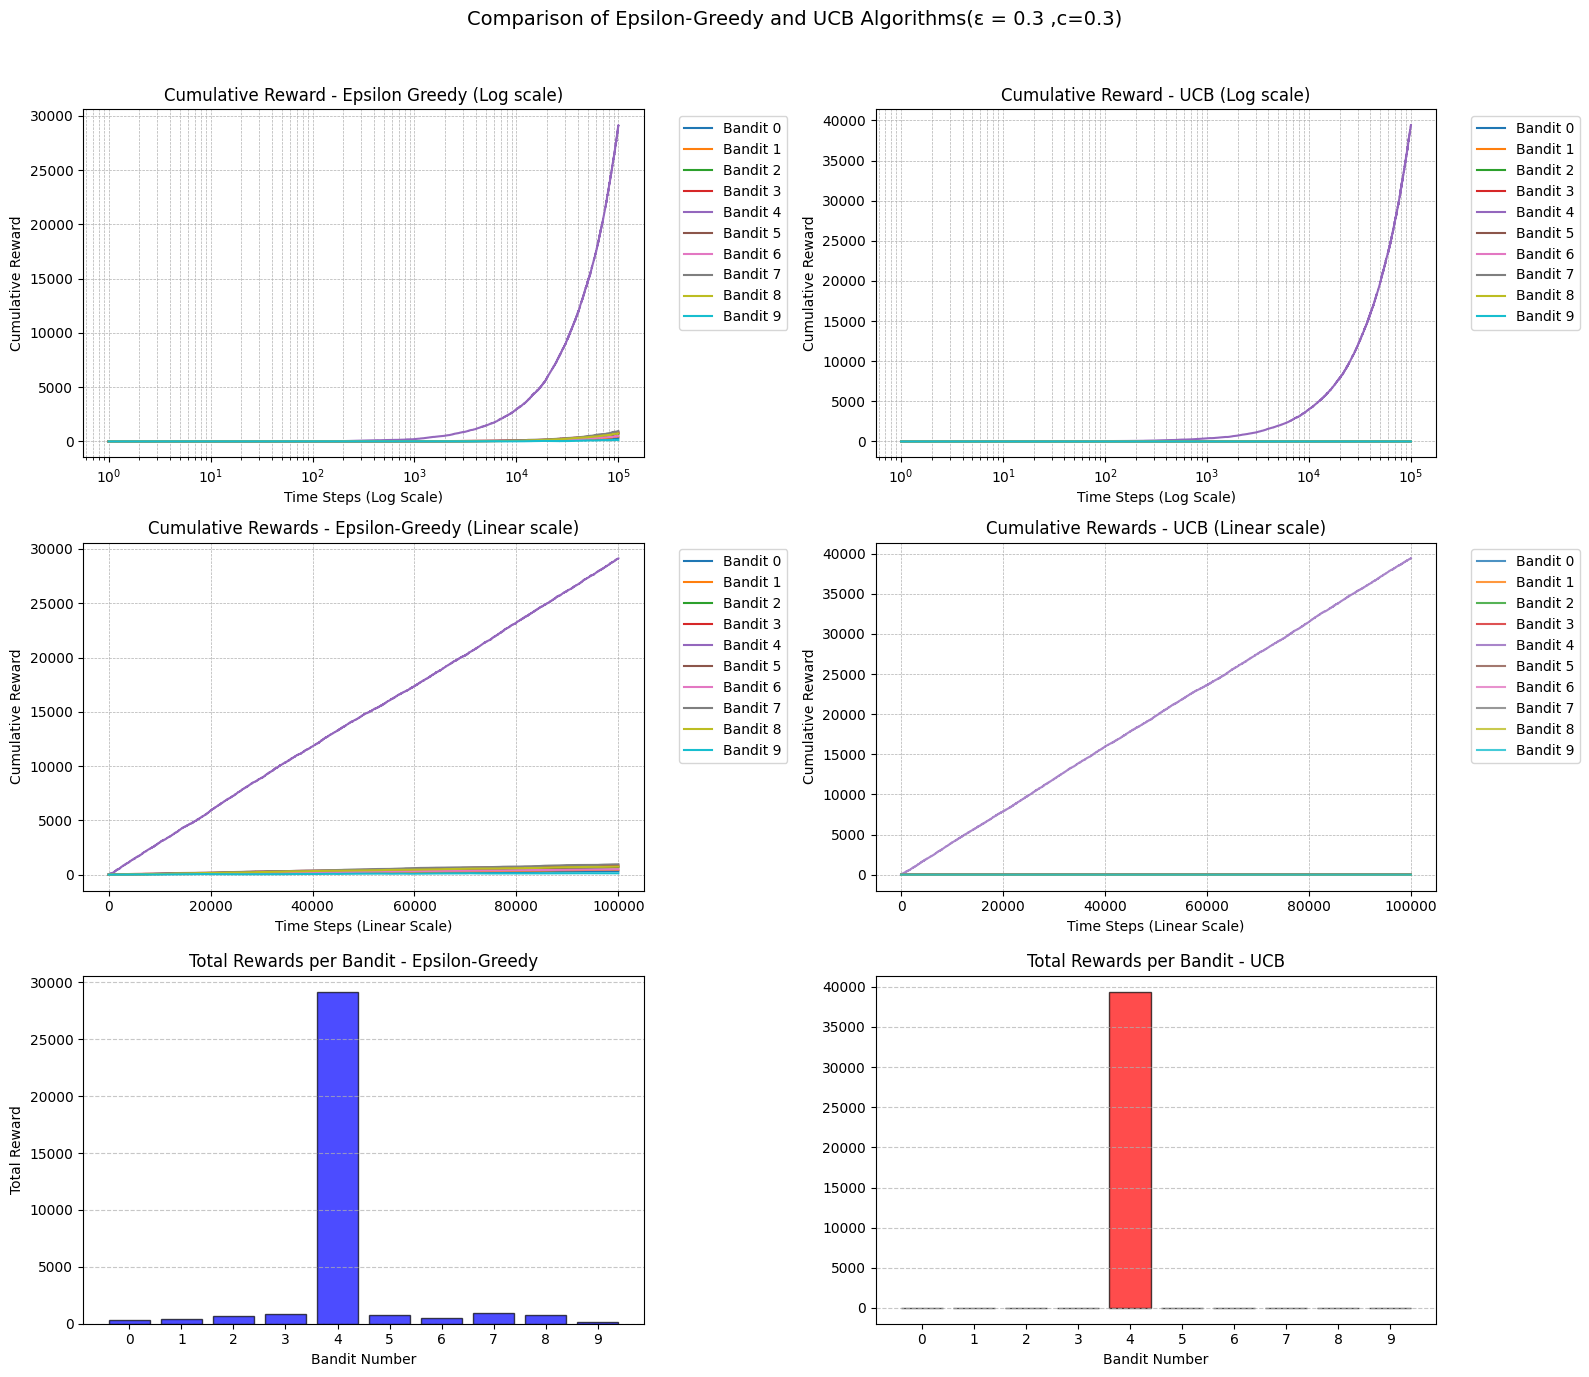

In [329]:
rew_epsilon_7, rew_ucb_7 = plot_results(n_bandits=n_bandits, rewards=rewards_each_bandit, sd=sd, time_steps=time_step, epsilon=epsilon_values[3], ucb_c=c_values[3])

### Summary for fixed configuration

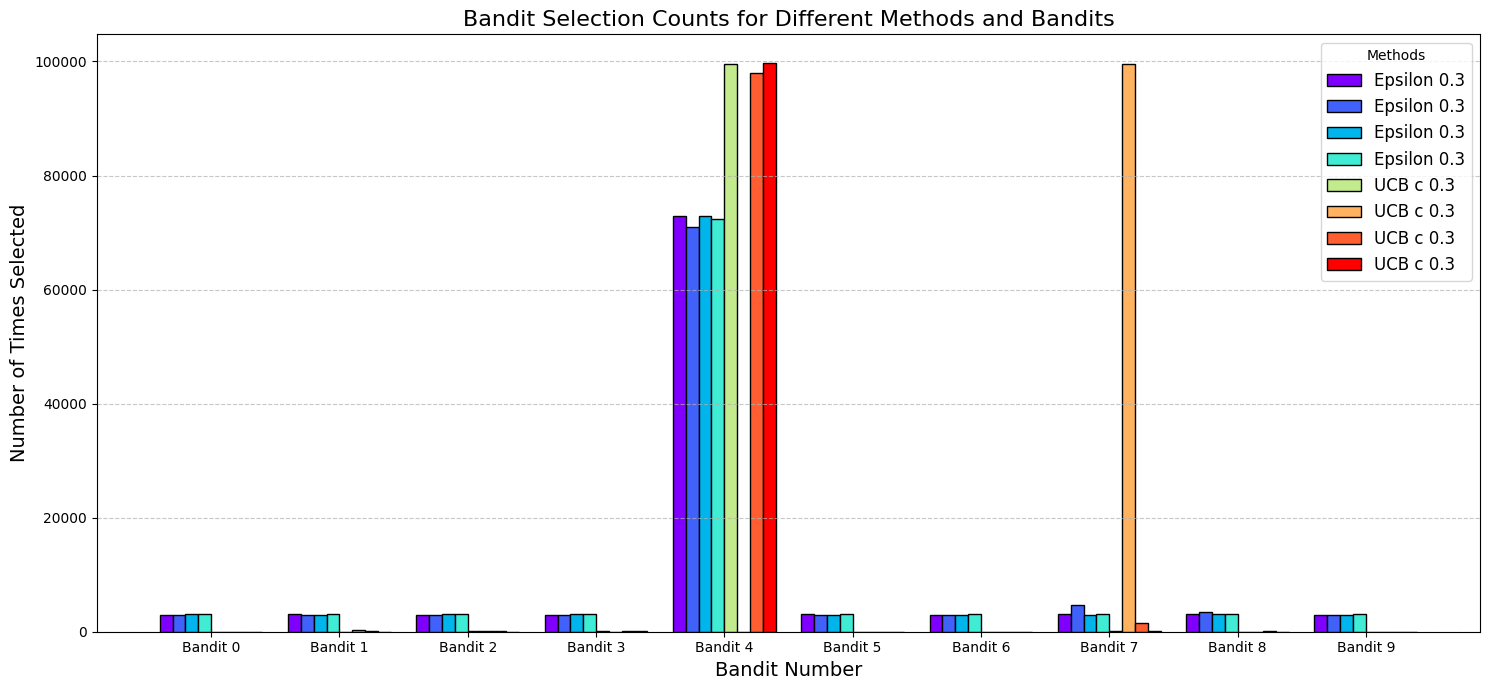

In [330]:
plot_bandit_selection_counts(
    reward_epsilon_list=[rew_epsilon_4, rew_epsilon_5, rew_epsilon_6, rew_epsilon_7],
    reward_ucb_list=[rew_ucb_4, rew_ucb_5, rew_ucb_6, rew_ucb_7],
    epsilon_values=epsilon_values,  # Example ε values
    c_values=c_values,  # Example UCB c values
    n_bandits=n_bandits
)


As this graph that try to use same config but run with multiple time. In all iteration of epsilon-greedy can select the best bandit true and distribute to another bundit is mostly same. In the UCB you will see in second time UCB has select bandit 7 as the best bandit,but another times select bandit 4 as the best bandit, so, this experiment can summarize that although you try to make same config with same environment.

- Epsilon-greedy select the best known bandit most of the time but sill explores other bandits 30% of the times.
- UCB prioritizes bandits with high uncertainty but eventually focus on the best bandit

- The bandit dominate the selections (bandit 4 and 7), meaning it likely has the higher expected reward but in some bandits are rarely chosen, indicating they provide lower rewards. From the under table you can see bandit 4 is the highest one and followed by bandit 7 that are the second highest of all bandit.

|Bandit|Value|
|------|------|
|0|0.1|
|1|0.15|
|2|0.21|
|3|0.25|
|**4**|**0.4 best!**|
|5|0.22|
|6|0.15|
|**7**|**0.3 runner up**|
|8|0.25|
|9|0.05|


## Summary 

**Epsilon greedy**

Explore randomly some percentage of time and exploit the best action the rest of the time 

<img src="epsilon_greedy.png" width="400" style="display: block; margin: auto; margin-bottom: 20px">

- Higher ε 
    - More exploration -> More random selection of bandits, prevent early convergence.
    - Slower convergence to optimal bandit.
- Lower ε
    - More exploitation -> Faster convergence to highest estimated reward
    - May getting struck in a suboptimal bandit

**Upper Confidence Bound (UCB)**

Optimistic and assume action we haven't tried much could be better

<img src="UCB.png" width="400" style="display: block; margin: auto; margin-bottom: 20px">

Where
- Qt(a) : current action value estimate for action (a) at time step (t)
- c : exploration parmater
- t : timesteps
- Nt(a) : Number of time action (a) is taken

That have 2 part Qt(a) that belief how good action (a) is, update using past observed rewards (Exploitation) and the second part in term of c time square root that are term of exploration. 

- Higher c 
    - More exploration
    - Slow down exploitation and delay convergence
- Lower c 
    - Less exploration 
    - Missing on better bandits
